In [1]:
from fastai.vision.all import *

In [2]:
#Loading Data

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
Path.BASE_PATH = path

In [4]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

In [5]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

In [6]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

In [7]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

In [8]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [9]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)

In [10]:
dset = list(zip(train_x,train_y))

In [11]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [12]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

In [13]:
#Initialization

In [14]:
def init_params(size, variance=1.0): return (torch.randn(size)*variance).requires_grad_()

In [15]:
#Loss

In [16]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [17]:
def mnist_loss(predictions, targets): 
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [18]:
#Linear Layer

In [19]:
def linear1(xb): return xb@weights + bias

In [20]:
def nonLinear(xb):
    res = xb@weights+bias
    res = res.max(tensor(0.0))
    return res

In [21]:
#Backpropogation

In [22]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward() #calculates gradient and adds to existing gradient

In [23]:
#Train epoch function

In [24]:
def train_epoch(model, lr, params):
    for xb, yb in dl: 
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr #tells Pytorch not to update the gradients using that calculation
            p.grad.zero_() #reset the gradients, _ is an inplace modifier

In [25]:
#Check Accuracy

In [26]:
def batch_accuracy(preds,yb):
    preds = preds.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [27]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb),yb) for xb, yb in valid_dl] #note: model(xb) = preds
    return round(torch.stack(accs).mean().item(), 4)

In [28]:
#Train model and check validation accuracy

In [29]:
weights = init_params((28*28,1))
bias = init_params(1)

In [30]:
params = weights, bias
epoch_num = 20
lr = 1.
for i in range(epoch_num):
    train_epoch(nonLinear, lr, params)
    print(validate_epoch(linear1), end=' ')

0.7545 0.8806 0.9162 0.9352 0.9435 0.9499 0.9543 0.9548 0.9577 0.9592 0.9611 0.9621 0.9626 0.9636 0.9656 0.9656 0.9675 0.968 0.968 0.968 

In [31]:
#Easier version

In [40]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [41]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [42]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [43]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.329335,0.408323,0.507851,00:00
1,0.152631,0.238785,0.793425,00:00
2,0.084361,0.120057,0.911678,00:00
3,0.055242,0.080848,0.938175,00:00
4,0.041764,0.062945,0.953876,00:00
5,0.034890,0.052877,0.962709,00:00
6,0.030942,0.046533,0.964181,00:00
7,0.028373,0.042204,0.965653,00:00
8,0.026515,0.039069,0.968597,00:00
9,0.025072,0.036680,0.969087,00:00


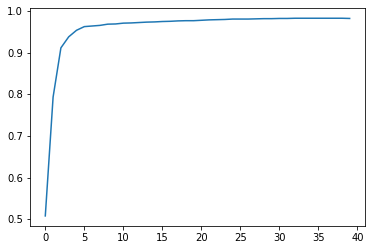

In [51]:
plt.plot(L(learn.recorder.values).itemgot(2)) #TODO: Find optimum learning rate

In [53]:
accuracy = learn.recorder.values[-1][2]; accuracy

0.98233562707901